# Digtial Signal Processing Toolkit Demo
---
## Necessary imports

In [1]:
import matplotlib.pyplot as plt
from dsp_toolkit.sample_data import sample_traces as st
import dsp_toolkit.filtering.xia_filters as tf
import dsp_toolkit.timing.constant_fraction_discriminators as cfd
import dsp_toolkit.signal_pileup.pileup as pu

## Trapezoidal Filtering
According to the pixie manual, the trapezoidal filters have the following basic form:

$LV_{x,k} = - \sum^{k-L-G}_{i=k-2L-G+1} V_i + \sum^{k}_{i=k-L+1}V_i$

Where $V$ is the signal, $L$ is the rise time of the trapezoidal filter and $G$ is the flat top
(gap) of the filter. The total length of the filter is then

$FilterLength = 2 * L + G$

The energy filter is actually a bit more complex than this since it takes into account the decay
constant of the previous signal. Here's an
[excellent article](https://doi.org/10.1109/NSSMIC.2008.4774600) about how the energy filtering is
implemented.

But you're here to see these functions in action. Let's take a peek.

### Choose our signal from the sample data

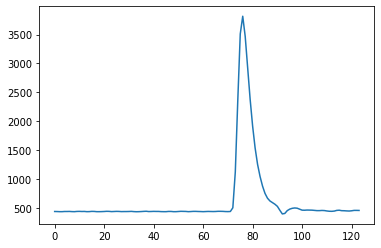

In [2]:
signal = st.plastic_scintillator
plt.plot(signal)

### Calculate the triggers and trigger filter response

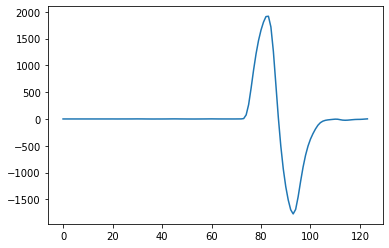

In [3]:

trig_params = {"l": 10, "g": 0, "t": 10}
triggers, trigger_filter = tf.calculate_trigger_filter(signal, trig_params['l'],
                                                    trig_params['g'], trig_params['t'])
baseline = tf.calculate_baseline(signal, triggers[0], trig_params['l'])
plt.plot(trigger_filter)

### Calculate the energy, energy filter limits, and energy filter coefficients.
We use the limits to actually calculate our energy sums, we then multiply those sums and add them
together to calculate the energy.

In [4]:
energy_params = {"l": 15, "g": 5, "t": 2.5}
energy_filter_coefficients = tf.calculate_energy_filter_coefficients(energy_params['l'], energy_params['t'])
energy_filter_limits = tf.calculate_energy_filter_limits(triggers[0], energy_params['l'], energy_params['g'], len(signal))
energy, esums = tf.calculate_energy(signal, baseline, energy_filter_coefficients, energy_filter_limits)

Let's see what our energy filter regions look like compared to our signal and the trigger position.

{'rising_sum': 3.745762711864245, 'gap_sum': 6.355932203389784, 'falling_sum': 19968.74576271186}


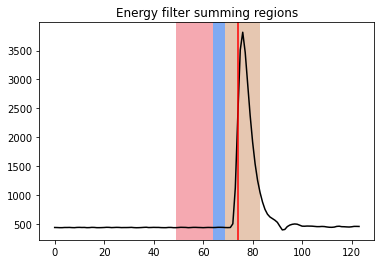

In [5]:
ax = plt.gca()
ax.set(title="Energy filter summing regions")
plt.plot(signal, color='black')
plt.axvline(x=triggers[0], color='red')
plt.axvspan(energy_filter_limits['rise'][0], energy_filter_limits['gap'][0], facecolor='#ed5565', alpha=0.5)
plt.axvspan(energy_filter_limits['gap'][0], energy_filter_limits['fall'][0], facecolor='#0157E7', alpha=0.5)
plt.axvspan(energy_filter_limits['fall'][0], energy_filter_limits['fall'][1], facecolor='#CF9065', alpha=0.5)
print(esums)

### Calculate the energy filter response

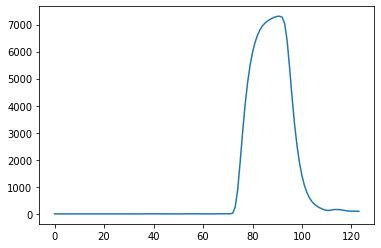

In [6]:
energy_filter = tf.calculate_energy_filter(signal, energy_params['l'], energy_params['g'], baseline, energy_filter_coefficients)
plt.plot(energy_filter)

### Put it all Together
We should note here that these sums and filters are getting continuously updated on the module. These
traces are hand-picked so that we can get performance similar to the on-board calculation.

(56.0, 124.0)

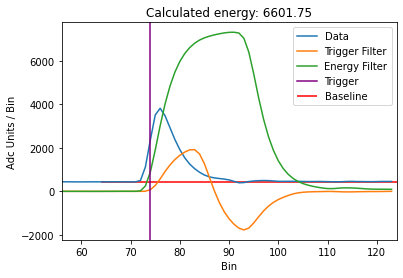

In [7]:
plt.plot(signal, label="Data")
plt.plot(trigger_filter, label="Trigger Filter")
plt.plot(energy_filter, label="Energy Filter")
for trigger in triggers:
    plt.axvline(x=trigger, color='purple', label="Trigger")
plt.hlines(y=baseline, xmin=triggers[0] - 10, xmax=len(signal), colors='red', label="Baseline")
plt.legend()
plt.gca().set(xlabel="Bin", ylabel='Adc Units / Bin', title=f"Calculated energy: {round(energy, 2)}")
plt.xlim([round(0.75 * triggers[0]), len(signal)])

## Constant Fraction Discrimination (CFD)
This is a timing method that triggers when the leading edge of the peak has reached a constant fraction.
To apply a CFD,
1. Duplicate the incoming signal.
2. Invert and delay the duplicate signal.
2. Multiply the original signal by a fraction.
3. Add the two signals together.

Your timing is then given by the zero-crossing point (ZCP). The advantage of this type of timing
is that your trigger is no longer dependent upon the signal amplitude. As I've detailed in
[other media](https://doi.org/10.1016/j.nima.2013.11.028), this timing method doesn't work when the
leading edge of your signal is locally non-linear. You end up in this situation when your digitizer
is slower than the signal you're capturing.

XIA's implementation on the Pixie-16 modules differs slightly from this recipe. They detail their
[implementation on Page 45 of the Pixie-16 Users's Manual](https://www.xia.com/Manuals/Pixie16_UserManual.pdf).

### Choosing our signal
As I mentioned, this method isn't great for really fast signals. We'll apply it to a slower one.

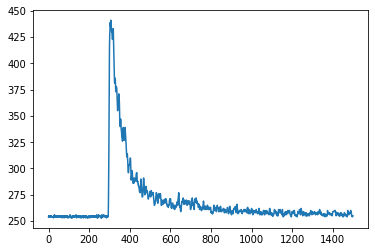

In [8]:
cfd_signal = st.csi
plt.plot(cfd_signal)

### Prepare our data
We need to calculate both of these since the CFD needs to work on a signal that's had its baseline
removed. Can't determine a zero-crossing point if your signal never crosses zero!

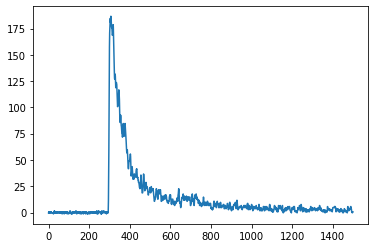

In [9]:
trigs, trig_filter = tf.calculate_trigger_filter(cfd_signal, 40, 10, 10)
baseline = tf.calculate_baseline(cfd_signal, trigs[0], 40)
munged_cfd_signal = [x - baseline for x in cfd_signal]
plt.plot(munged_cfd_signal)

### Traditional CFD
We calculate this CFD with the method described above. Do some inversion, scaling, delaying and adding.

(223.0, 371.0)

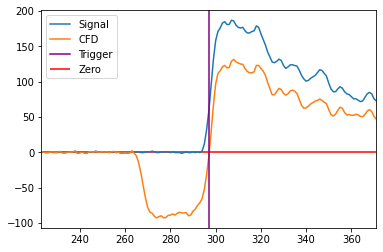

In [10]:
trad_trigger, trad_cfd = cfd.calculate_traditional_cfd(munged_cfd_signal, 30, 0.50)

ax = plt.gca()
plt.plot(munged_cfd_signal, label="Signal")
plt.plot(trad_cfd, label="CFD")
plt.axvline(x=trad_trigger, color='purple', label="Trigger")
plt.hlines(y=0, xmin=0, xmax=len(munged_cfd_signal), colors='red', label="Zero")
plt.legend()
plt.xlim([round(0.75 * trad_trigger), round(1.25 * trad_trigger)])

### XIA's CFD
This one is a bit different than the traditional. In this case we're actually working off of the
results of the trigger filter.

(231.0, 385.0)

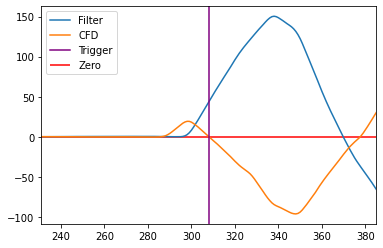

In [11]:
xia_trigger, xia_response = cfd.calculate_xia_cfd(trig_filter, 10, 4)

plt.plot(trig_filter, label="Filter")
plt.plot(xia_response, label="CFD")
plt.axvline(x=xia_trigger, color='purple', label="Trigger")
plt.hlines(y=0, xmin=0, xmax=len(trig_filter), colors='red', label="Zero")
plt.legend()
plt.xlim([round(0.75 * xia_trigger), round(1.25 * xia_trigger)])

## Signal Pile-up Simulation
There are times when you just really need to understand what your spectrum looks like when two signals
land on top of each other, or nearly on top of each other. To do that you need to understand a bit
about how the energy is calculated, and some characteristics about your signal. Thankfully,
the energy information is listed above!

### Configuration

In [12]:
pileup_config = {
    "event_rate": 41600,
    "number_of_events": 10000,
    "sampling_interval": 10.e-9,
    "signal": {
        # Parameters for CsI(Na)
        "rise_time": 0.10e-6,
        "decay_time": 0.76e-6
    },
    "filter": {
        "length": 0.20e-6,
        "gap": 0.64e-6,
        "tau": 0.86e-6
    }
}

### Gaussian Distribution
First, let's see what this guy looks like with a simple Gaussian distribution. In this case we won't
provide the spectrum weights. The code will automatically calculate the rates based on the
distribution.

(80.0, 220.0)

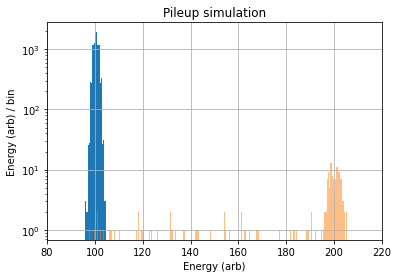

In [13]:
from random import gauss

energy_spectrum = [gauss(100, 1) for x in range(0, pileup_config['event_rate'])]

signal, pileup = pu.generate_pileups(pileup_config, pu.model_xia_pixie16_filter, energy_spectrum)

bins = 300
plt.hist(signal, label="signal", bins=bins*2, range=[0, bins])
plt.hist(pileup, label="pileup", bins=bins*2, range=[0, bins], alpha=0.5)
plt.grid(True)
plt.gca().set(xlabel="Energy (arb)", ylabel='Energy (arb) / bin', title=f"Pileup simulation", yscale='log')
plt.xlim(80, 220)

### <sup>137</sup>Cs Spectrum
For this run we'll use a <sup>137</sup>Cs spectrum taken with a rate of 8000 counts per second. The
spectrum originally comes from ROOT. The ROOT binning on the spectrum was a factor of 2. So we have
662 keV -> bin 1324. All data points in the array has a tuple with the bin and the count in that bin.

In [14]:
from numpy import random
from dsp_toolkit.sample_data.sample_energy_spectra import cs137_8k_cps_spectrum
root_binning_factor = 2

choices = [x[0] / root_binning_factor for x in cs137_8k_cps_spectrum]
counts = [x[1] for x in cs137_8k_cps_spectrum]
weights = [x / sum(counts) for x in counts]

Let's make sure that we end up with the right spectrum first.

(0.0, 800.0)

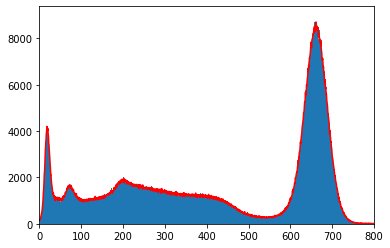

In [15]:
plt.plot(choices, counts, color="red")
plt.hist(random.choice(choices, 2563370, p=weights), bins=800 * root_binning_factor, range=[0, 800])
plt.xlim([0, 800])

Looks pretty good! Let's see what we can do with the pileup now.

(0.0, 800.0)

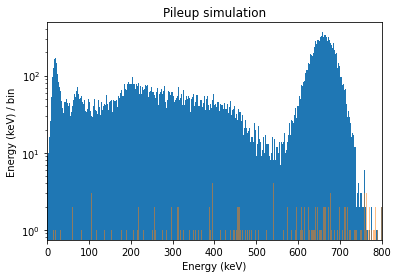

In [16]:
cs_config = {
    "event_rate": 30000,
    "number_of_events": 1e5,
    "sampling_interval": 10.e-9,
    "signal": {
        # Parameters for CsI(Na)
        "rise_time": 0.10e-6,
        "decay_time": 0.76e-6
    },
    "filter": {
        "length": 0.20e-6,
        "gap": 0.64e-6,
        "tau": 0.86e-6
    }
}

cs_signal, cs_pileup = pu.generate_pileups(cs_config, pu.model_xia_pixie16_filter, choices, weights)

bins = 800
plt.hist(cs_signal, label='signal', bins=bins*2, range=[0, bins])
plt.hist(cs_pileup, label="pileup", bins=bins*2, range=[0, bins], alpha=0.5)
plt.gca().set(xlabel="Energy (keV)", ylabel='Energy (keV) / bin', title=f"Pileup simulation",
              yscale='log')
plt.xlim([0, 800])